# 0. Imports & inputs & introductions

This files is written to compare the data sent from James Sturch to compare the mismatch results using Solar Edge system. The email was sent by Jame Sturch and the date was 20/11/2024.

In [1]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime
from datetime import timedelta
import scipy.constants as const
import matplotlib.dates as mdates


# data folder direcotry
data_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results"
# directory for the results folder to investigate for session 6
results_dir = r'C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# Define the site to read
# site_id = '1398284'  # Site identifier
# site_id = '347166'
# site_id = '4129142'
# site_id = '3499407'
# site_id = '378878'
# site_id = '3794347'
# site_id = '3996237'
site_id = '3455043'


# define the season
# season = 'summer'
season = 'spring'
# season = 'winter'
# season = 'autumn'

# define the module parameter
# ideality_factor = 0.954526056
# num_cells_series = 120
# thermal_voltage_25C = 0.0258
# series_resistance = 0.229
# shunt_resistance = 300

if site_id == '347166':
    ideality_factor = 1.0081
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.302
    shunt_resistance = 400
elif site_id == '1398284':
    ideality_factor = 0.954526056
    num_cells_series = 120
    thermal_voltage_25C = 0.0258
    series_resistance = 0.229
    shunt_resistance = 300
elif site_id == '4129142':
    ideality_factor = 1.029
    num_cells_series = 72
    thermal_voltage_25C = 0.0258
    series_resistance = 0.269
    shunt_resistance = 600
elif site_id == '3499407':
    ideality_factor = 1.03
    num_cells_series = 72
    thermal_voltage_25C = 0.0258
    series_resistance = 0.29
    shunt_resistance = 350
elif site_id == '378878':
    ideality_factor = 0.994
    num_cells_series = 60
    thermal_voltage_25C = 0.0258
    series_resistance = 0.176
    shunt_resistance = 1000
elif site_id == '3794347':
    ideality_factor = 1.039
    num_cells_series = 54*2
    thermal_voltage_25C = 0.0258
    series_resistance = 0.133
    shunt_resistance = 1200
elif site_id == '3996237':
    ideality_factor = 1.025
    num_cells_series = 54*2
    thermal_voltage_25C = 0.0258
    series_resistance = 0.161
    shunt_resistance = 260

# Determine fixed x and y axis limits for all plots that plot for each module
y_limit_module = (0, 15)
x_limit_module = (0, 60)  # Assuming a reasonable range for combined voltages

# Determine fixed x and y axis limits for all plots that plot for the combined inverter
y_limit_inverter = (0, 15)
x_limit_inverter = (0, 1200)  # Adjust for combined voltages

# Option to dynamically calculate vth based on panel temperature
use_dynamic_vth = True  # Set to True to enable dynamic calculation, False to use thermal_voltage_25C

# Option to replace the panel temperature with the temperature, the reason to do this is that the module temperature looks too high but the ambient tmperature looks like module temperature
use_a_T = True  # Set to True to use ambient temperature, False to use module temperature

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)

In [2]:
# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL


# 1. Read & visualise

## 1.1. Find the site folder

In [3]:
# Find the directory containing the site_id
site_dir = [d for d in os.listdir(data_dir) if site_id in d][0]

# Full path to the site directory
site_dir = os.path.join(data_dir, site_dir)

print(f"Reading data from {site_dir}")

Reading data from C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\3455043


## 1.2. Season data extraction

### 1.2.1. Data extraction

In [4]:
# Define a mapping from season to a list of month names (all in lowercase)
season_months = {
    'summer': ['december', 'january', 'february'],
    'autumn': ['march', 'april', 'may'],
    'winter': ['june', 'july', 'august'],
    'spring': ['september', 'october', 'november']
}

# Ensure the season is in lowercase for matching
season_lower = season.lower()

# Find the folder that contains the season word or any month name corresponding to that season
season_dir_candidates = [
    d for d in os.listdir(site_dir)
    if (season_lower in d.lower() or any(month in d.lower() for month in season_months.get(season_lower, [])))
]

if not season_dir_candidates:
    raise ValueError("No folder found that contains the specified season or its corresponding months.")

# Choose the first matching folder (or adjust the selection logic as needed)
season_dir = season_dir_candidates[0]

# Full path to the season directory
season_dir = os.path.join(site_dir, season_dir)
print("Season directory found:", season_dir)

# Initialize empty lists to store the DataFrames and reporter IDs
dataframes = []
reporter_ids = []

# Define a list of potential timestamp formats
timestamp_formats = [
    "%Y-%m-%d %H:%M:%S",
    "%d/%m/%Y %H:%M",
    "%m/%d/%Y %H:%M",
    "%Y-%d-%m %H:%M:%S",
    None  # Let pandas infer formats
]

# Get a list of CSV files in the season directory that contain "optimizer_data"
csv_files = [f for f in os.listdir(season_dir) if 'optimizer_data' in f and f.endswith('.csv')]

if not csv_files:
    raise ValueError("No CSV files found in season directory.")

# If only one CSV file exists, check if it contains a 'reporter_id' column.
if len(csv_files) == 1:
    file = csv_files[0]
    file_path = os.path.join(season_dir, file)
    df = pd.read_csv(file_path)
    
    if 'reporter_id' in df.columns:
        # Process the single CSV file by splitting it by reporter_id.
        unique_reporters = df['reporter_id'].unique()
        for reporter in unique_reporters:
            df_rep = df[df['reporter_id'] == reporter].copy()
            # Rename the first column to "Timestamp" if not already
            if df_rep.columns[0] != 'Timestamp':
                df_rep.rename(columns={df_rep.columns[0]: 'Timestamp'}, inplace=True)
            
            # Define a mapping for renaming relevant columns to include the reporter id
            rename_map = {
                'panel_current': f'panel_current_{reporter}',
                'panel_voltage': f'panel_voltage_{reporter}',
                'temperature': f'temperature_{reporter}',
                'panel_temperature': f'panel_temperature_{reporter}',
                'power': f'power_{reporter}'
            }
            df_rep.rename(columns=rename_map, inplace=True)
            
            # Convert the "Timestamp" column to datetime using potential formats
            for fmt in timestamp_formats:
                try:
                    df_rep['Timestamp'] = pd.to_datetime(df_rep['Timestamp'], format=fmt)
                    break
                except (ValueError, TypeError):
                    pass
            
            # Set the index to the Timestamp
            df_rep.set_index('Timestamp', inplace=True)
            # Keep only the renamed columns
            df_rep = df_rep[list(rename_map.values())]
            dataframes.append(df_rep)
            reporter_ids.append(str(reporter))
    else:
        # Single CSV file but without a 'reporter_id' column.
        # Treat the entire file as coming from a default reporter.
        default_reporter = "default"
        if df.columns[0] != 'Timestamp':
            df.rename(columns={df.columns[0]: 'Timestamp'}, inplace=True)
        rename_map = {
            'panel_current': f'panel_current_{default_reporter}',
            'panel_voltage': f'panel_voltage_{default_reporter}',
            'temperature': f'temperature_{default_reporter}',
            'panel_temperature': f'panel_temperature_{default_reporter}',
            'power': f'power_{default_reporter}'
        }
        df.rename(columns=rename_map, inplace=True)
        for fmt in timestamp_formats:
            try:
                df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=fmt)
                break
            except (ValueError, TypeError):
                pass
        df.set_index('Timestamp', inplace=True)
        df = df[list(rename_map.values())]
        dataframes.append(df)
        reporter_ids.append(default_reporter)
else:
    # Multiple CSV files case (each file corresponding to one optimizer)
    for file in csv_files:
        file_path = os.path.join(season_dir, file)
        optimizer_data = pd.read_csv(file_path)
        
        # Extract the reporter_id from the file name (assuming it is the last part before the extension)
        reporter_id = file.split('_')[-1].split('.')[0]
        reporter_ids.append(reporter_id)
        
        optimizer_data.rename(columns={
            'panel_current': f'panel_current_{reporter_id}',
            'panel_voltage': f'panel_voltage_{reporter_id}',
            'temperature': f'temperature_{reporter_id}',
            'panel_temperature': f'panel_temperature_{reporter_id}',
            'power': f'power_{reporter_id}'
        }, inplace=True)
        
        if optimizer_data.columns[0] != 'Timestamp':
            optimizer_data.rename(columns={optimizer_data.columns[0]: 'Timestamp'}, inplace=True)
        
        for fmt in timestamp_formats:
            try:
                optimizer_data['Timestamp'] = pd.to_datetime(optimizer_data['Timestamp'], format=fmt)
                break
            except (ValueError, TypeError):
                pass
        
        optimizer_data.set_index('Timestamp', inplace=True)
        optimizer_data = optimizer_data[[f'panel_current_{reporter_id}', f'panel_voltage_{reporter_id}',
                                         f'temperature_{reporter_id}', f'panel_temperature_{reporter_id}',
                                         f'power_{reporter_id}']]
        dataframes.append(optimizer_data)

# Synchronize timestamps across all DataFrames:
if dataframes:
    # Find the overlapping time window by using the maximum start time and the minimum end time.
    earliest_timestamp = max([df.index[0] for df in dataframes])
    latest_timestamp = min([df.index[-1] for df in dataframes])
    # Create a new index with a 5-minute frequency.
    new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')
    
    # Reindex each DataFrame, inserting NaN for missing timestamps.
    for i in range(len(dataframes)):
        for index in new_index:
            if index not in dataframes[i].index:
                dataframes[i].loc[index] = np.nan
    
    # Merge all DataFrames on the Timestamp index.
    merged_data = pd.concat(dataframes, axis=1)
    # Reset the index so that Timestamp becomes a column.
    merged_data.reset_index(inplace=True)

if use_a_T:
    print("Using ambient temperature")
    # Remove any column whose name contains "panel_temperature"
    cols_to_drop = [col for col in merged_data.columns if 'panel_temperature' in col]
    merged_data.drop(columns=cols_to_drop, inplace=True)
    
    # For each column that contains "temperature", create a duplicate column 
    # with the name changed from "temperature" to "panel_temperature"
    for col in [col for col in merged_data.columns if 'temperature' in col]:
        new_col = col.replace('temperature', 'panel_temperature')
        merged_data[new_col] = merged_data[col]
    
print(merged_data)


Season directory found: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\3455043\september


C:\Users\z5183876\AppData\Local\Temp\ipykernel_20400\3668003980.py:150: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  new_index = pd.date_range(start=earliest_timestamp, end=latest_timestamp, freq='5T')


Using ambient temperature
               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_22

### 1.2.2. Visualisation

#### 1.2.2.1. Include temperature

               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_226780324  panel_current_226

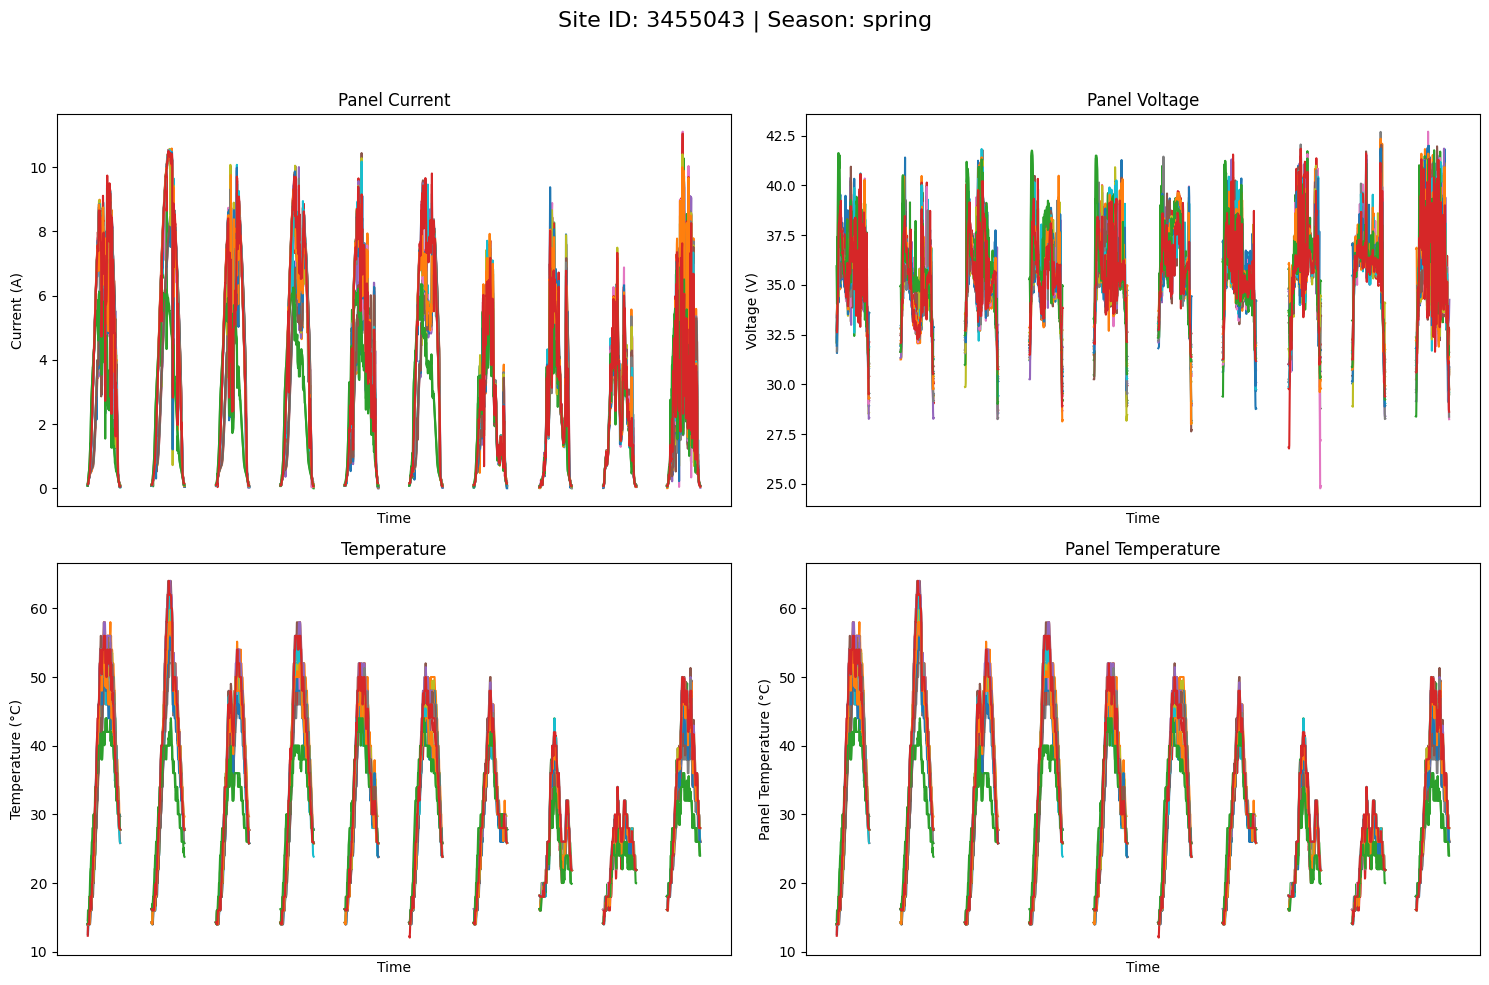

In [5]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 2x2 subplot for the data
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Add a figure-level title with site ID and season
fig.suptitle(f"Site ID: {site_id} | Season: {season}", fontsize=16)

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0, 0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'])
axs[0, 0].set_title('Panel Current')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Current (A)')
axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[0, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'])
axs[0, 1].set_title('Panel Voltage')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Voltage (V)')
axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all temperatures
for reporter_id in reporter_ids:
    axs[1, 0].plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'])
axs[1, 0].set_title('Temperature')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Temperature (°C)')
axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Plot all panel temperatures
for reporter_id in reporter_ids:
    axs[1, 1].plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'])
axs[1, 1].set_title('Panel Temperature')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Panel Temperature (°C)')
axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Remove x-ticks

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()


#### 1.2.2.2. Exclude temperature

               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_226780324  panel_current_226

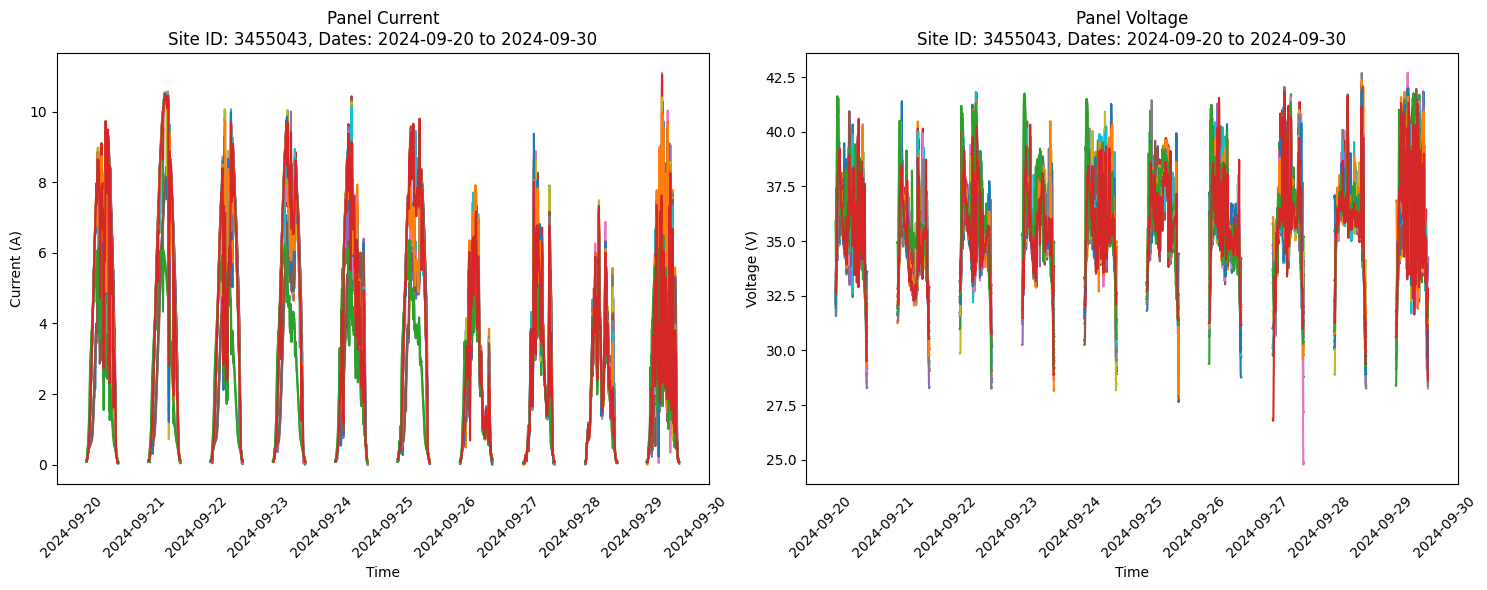

In [6]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Create a 1x2 subplot for panel current and panel voltage
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Format the date range for the title
date_range_str = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"

# Plot all panel currents
for reporter_id in reporter_ids:
    axs[0].plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'], label=f'Panel {reporter_id}')
axs[0].set_title(f'Panel Current\nSite ID: {site_id}, Dates: {date_range_str}')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Current (A)')
axs[0].tick_params(axis='x', which='both', bottom=False, labelrotation=45)

# Plot all panel voltages
for reporter_id in reporter_ids:
    axs[1].plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'], label=f'Panel {reporter_id}')
axs[1].set_title(f'Panel Voltage\nSite ID: {site_id}, Dates: {date_range_str}')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Voltage (V)')
axs[1].tick_params(axis='x', which='both', bottom=False, labelrotation=45)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


#### 1.2.2.3. Individual plots

               Timestamp  panel_current_226780324  panel_voltage_226780324  \
0    2024-09-20 05:45:00                      NaN                      NaN   
1    2024-09-20 05:50:00                      NaN                      NaN   
2    2024-09-20 05:55:00                 0.107708                31.586310   
3    2024-09-20 06:00:00                 0.148265                31.744983   
4    2024-09-20 06:05:00                 0.208990                33.404110   
...                  ...                      ...                      ...   
2733 2024-09-29 17:30:00                 0.167100                30.680203   
2734 2024-09-29 17:35:00                 0.121352                30.142023   
2735 2024-09-29 17:40:00                 0.081226                29.704280   
2736 2024-09-29 17:45:00                 0.062500                29.500000   
2737 2024-09-29 17:50:00                      NaN                      NaN   

      temperature_226780324  power_226780324  panel_current_226

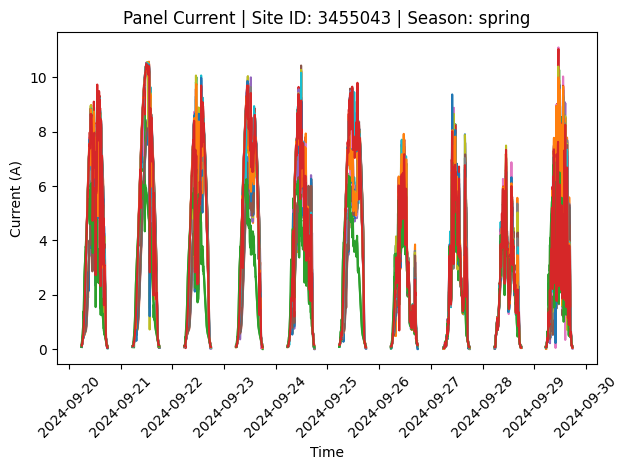

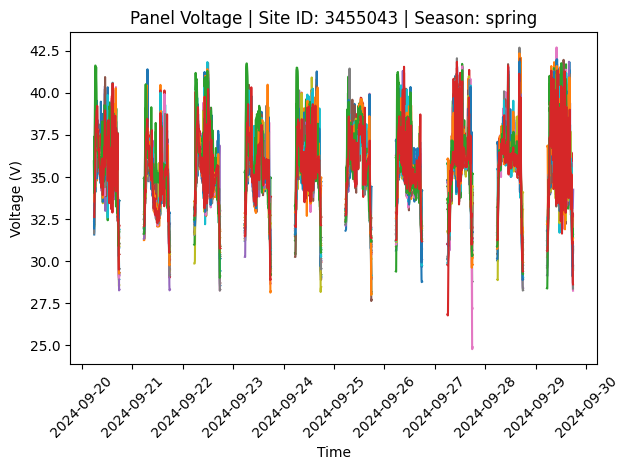

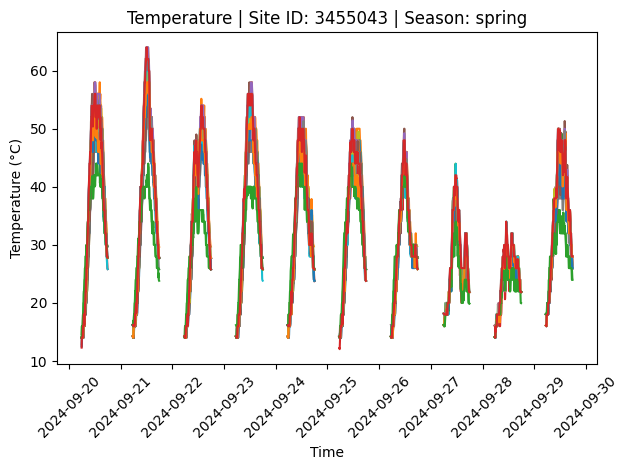

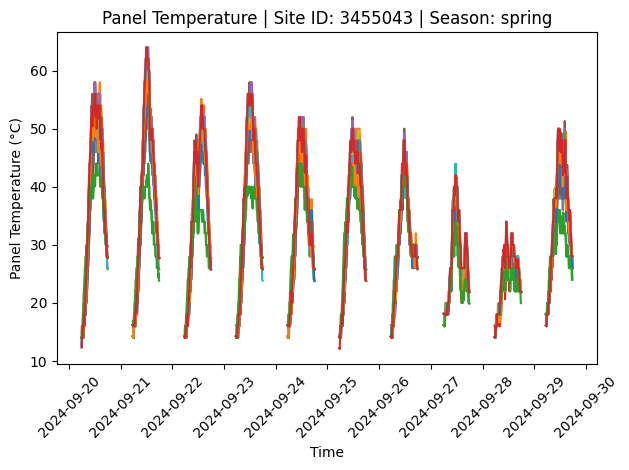

In [7]:
# Specify the number of days to plot
num_days_to_plot = 10

# Filter the data for the specified number of days
start_date = pd.to_datetime(merged_data['Timestamp'].iloc[0])
end_date = start_date + timedelta(days=num_days_to_plot)
filtered_data = merged_data[(pd.to_datetime(merged_data['Timestamp']) >= start_date) & 
                            (pd.to_datetime(merged_data['Timestamp']) < end_date)]

print(filtered_data)

# Plot Panel Current in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_current_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Current | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Current (A)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Panel Voltage in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_voltage_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Voltage | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Temperature in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'temperature_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Temperature | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Panel Temperature in an individual figure
plt.figure()
for reporter_id in reporter_ids:
    plt.plot(filtered_data['Timestamp'], filtered_data[f'panel_temperature_{reporter_id}'], label=f'Panel {reporter_id}')
plt.title(f'Panel Temperature | Site ID: {site_id} | Season: {season}')
plt.xlabel('Time')
plt.ylabel('Panel Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.3. Module spec extraction

In [8]:
# find the .PAN file in the site_dir
pan_file = [f for f in os.listdir(site_dir) if f.endswith('.PAN')][0]

# read the .PAN file
pan_file_path = os.path.join(site_dir, pan_file)

with open(pan_file_path, 'r') as f:
    pan_data = f.readlines()
    # find the line that contains the "RSeries"
    for line in pan_data:
        if 'RSeries' in line:
            series_resistance = float(line.split('=')[1].strip())
            print(f"Series Resistance from PAN file: {series_resistance}")
    # find the line that contains the "RShunt"
    for line in pan_data:
        if 'RShunt' in line:
            shunt_resistance = float(line.split('=')[1].strip())
            print(f"Shunt Resistance from PAN file: {shunt_resistance}")
    # find the line that contains the "NCelS" as the number of cells in series
    for line in pan_data:
        if 'NCelS' in line:
            num_cells_series = int(line.split('=')[1].strip())
            print(f"Number of cells in series from PAN file: {num_cells_series}")
    # find the line that contains the "Gamma" as the ideality factor
    for line in pan_data:
        if 'Gamma' in line:
            ideality_factor = float(line.split('=')[1].strip())
            print(f"Ideality factor from PAN file: {ideality_factor}")
            break  # Exit the loop after finding the ideality factor

Series Resistance from PAN file: 0.13
Shunt Resistance from PAN file: 450.0
Number of cells in series from PAN file: 66
Ideality factor from PAN file: 1.045


# 2. Series connection power calculation

## 2.1. One diode model data extraction

The data of module they get it from PVsyst database, which is CS6K - 315MS from CSI Solar. Therefore I go to PVsyst, find the module and extract n, Ncell, Rs, Rsh, then put it below.

In [9]:
# Parameters for the one-diode model
# if site_id == '347166':
#     ideality_factor = 1.0081
#     num_cells_series = 60
#     thermal_voltage_25C = 0.0258
#     series_resistance = 0.302
#     shunt_resistance = 400
# elif site_id == '1398284':
#     ideality_factor = 0.954526056
#     num_cells_series = 120
#     thermal_voltage_25C = 0.0258
#     series_resistance = 0.229
#     shunt_resistance = 300

# # Constants for vth calculation
boltzmann_constant = const.Boltzmann  # Boltzmann constant in J/K
electron_charge = const.e  # Elementary charge in C

## 2.2. Calculate IV curves from MPPT

### 2.2.1. Include the power output (debugging)

In [10]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrames to store the sum of I*V and total power for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])
# total_power_data = pd.DataFrame(columns=['Timestamp', 'Total Power (W)'])

# # Determine fixed x and y axis limits for all plots
# y_limit = (0, 13)
# x_limit = (0, 50)  # Assuming a reasonable range for combined voltages

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit[1], 100)

# for idx in range(len(merged_data)):
#     plt.figure(figsize=(10, 6))
#     sum_iv = 0
#     total_power = 0

#     for optimiser in reporter_ids:
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         optimiser_power = merged_data[f'power_{optimiser}']

#         is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
#                          np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

#         if not is_nan_or_zero:
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]
#             panel_power = optimiser_power.iloc[idx]

#             # Add to sums
#             sum_iv += panel_voltage * panel_current
#             total_power += panel_power

#             # IV Curve Calculation
#             vth = boltzmann_constant * (merged_data[f'panel_temperature_{optimiser}'].iloc[idx] + 273.15) / electron_charge
#             params = {
#                 'photocurrent': panel_current,
#                 'saturation_current': I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth),
#                 'resistance_series': series_resistance,
#                 'resistance_shunt': shunt_resistance,
#                 'nNsVth': ideality_factor * num_cells_series * vth,
#             }
#             voltage_iv = pvlib.pvsystem.v_from_i(current=currents, **params)

#             # Plot IV curve
#             plt.plot(voltage_iv, currents, label=f'IV Curve - {optimiser}')

#             # Plot MPPT Point
#             plt.plot(panel_voltage, panel_current, 'ro', label=f'MPPT - {optimiser}')

#     # Store data for this timestamp
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)
#     total_power_data = pd.concat([total_power_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Total Power (W)': [total_power]})], ignore_index=True)

#     # Finalize plot
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W, Total Power: {total_power:.2f} W')
#     plt.grid(True)
#     plt.xlim(x_limit)
#     plt.ylim(y_limit)

#     # Save the plot
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path)
#     plt.close()
#     image_files.append(file_path)



### 2.2.2. IV sum

In [11]:
# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF
# image_files = []

# # DataFrame to store the sum of I*V for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit_module[1], 100)

# # Loop through each time step
# for idx in range(len(merged_data)):

#     # Create a new figure for each time step
#     plt.figure(figsize=(10, 6))

#     # Initialize a counter for the number of IV curves in the plot
#     iv_curve_count = 0
#     sum_iv = 0  # Initialize sum of I*V

#     # Skip this time step if all optimizers have NaN or zero values
#     all_nan_or_zero = all(
#         merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
#         merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
#         np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
#         np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
#         for optimiser in reporter_ids
#     )
#     if all_nan_or_zero:
#         print(f"Time step {idx} has NaN or zero values for all optimizers.")
#         continue

#     # Loop through each optimiser
#     for optimiser in reporter_ids:
#         # Extract the IV data from the optimiser for the current time step
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # Panel temperature in °C

#         # Check if there are any NaN or zero values in the current and voltage
#         is_nan_or_zero = optimiser_voltage.iloc[idx] == 0 or optimiser_current.iloc[idx] == 0 or \
#                          np.isnan(optimiser_voltage.iloc[idx]) or np.isnan(optimiser_current.iloc[idx])

#         if is_nan_or_zero:
#             # If there are NaN or zero values, set voltage to zero for the entire current range
#             voltage = np.zeros_like(currents)
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
#             print(f"Time step {idx} has NaN or zero values for Optimizer {optimiser}.")
#         else:
#             # Convert panel temperature to Kelvin
#             panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

#             # Calculate vth dynamically or use the fixed value
#             if use_dynamic_vth:
#                 vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
#             else:
#                 vth = thermal_voltage_25C

#             # Extract voltage and current for the current time step
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]

#             # Add I*V to the sum for this optimizer
#             sum_iv += panel_voltage * panel_current

#             # Calculate the I0 at the operating point for the current time step
#             I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)

#             # Calculate the IL at the operating point for the current time step
#             IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

#             # Use the single diode model to calculate voltage for each current point
#             params = {
#                 'photocurrent': IL_op,  # Photocurrent (light-generated current)
#                 'saturation_current': I0_op,  # Saturation current
#                 'resistance_series': series_resistance,  # Series resistance
#                 'resistance_shunt': shunt_resistance,  # Shunt resistance
#                 'nNsVth': ideality_factor * num_cells_series * vth  # Ideality factor * Cells in series * Thermal voltage
#             }

#             # Calculate voltage for each current point using the single diode model
#             voltage = pvlib.pvsystem.v_from_i(
#                 current=currents,
#                 photocurrent=params['photocurrent'],
#                 saturation_current=params['saturation_current'],
#                 resistance_series=params['resistance_series'],
#                 resistance_shunt=params['resistance_shunt'],
#                 nNsVth=params['nNsVth']
#             )

#             # Plot the IV curve for the current time step on the same axis
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')

#             # Mark the panel voltage and panel current at this point
#             plt.plot(panel_voltage, panel_current, 'ro')  # Mark with a red circle

#         # Increment the counter for each plotted IV curve
#         iv_curve_count += 1

#     # Print out the number of IV curves in the plot
#     print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

#     # Store the sum of I*V in the DataFrame
#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

#     # Set consistent x and y axis limits for all plots
#     plt.xlim(x_limit_module)
#     plt.ylim(y_limit_module)

#     # Finalize the plot for the current time step
#     plt.xlabel('Voltage (V)')
#     plt.ylabel('Current (A)')
#     plt.title(f'IV Curves at {timestamp_title}\nSum of I*V: {sum_iv:.2f} W')
#     plt.grid(True)

#     # Save the plot as a PNG file with "summer/winter" and site_id in the file name
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path)
#     plt.close()

#     # Add the file path to the list for GIF creation
#     image_files.append(file_path)

# # Save the sum of I*V data to an Excel file
# excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
# iv_sum_data.to_excel(excel_path, index=False)
# print(f"Excel file saved as: {excel_path}")

# # Create a GIF from the saved images with slower speed and loop indefinitely
# gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
# with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
#     for filename in image_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as '{gif_path}'")


### 2.2.3. With Raw data

In [12]:
# # ============================
# # Option to choose optimizers to run:
# # If selected_optimizers is defined as a list (e.g. below), only those optimizers will be processed.
# # If it is set to None, the code will run for all optimizers (i.e. all IDs in reporter_ids).
# # ============================
# # the reason to have this option is to allow visualisation of a certain PV module
# # selected_optimizers = ['241622244', '241622317', '241622327', '249776740']  
# # To run for all optimizers, simply set:
# selected_optimizers = None

# # calculate the thermal voltage at 25 degrees Celsius
# thermal_voltage_25C = boltzmann_constant * (25 + 273.15) / electron_charge

# # Determine which optimizers to run:
# if selected_optimizers is not None:
#     optimizers_to_run = [opt for opt in reporter_ids if opt in selected_optimizers]
# else:
#     optimizers_to_run = reporter_ids

# # Get the current timestamp when the code is run
# timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}_{season}_{site_id}')
# os.makedirs(output_dir, exist_ok=True)

# # List to keep track of file paths for the GIF (for reconstructed IV plots)
# image_files = []

# # DataFrame to store the sum of I*V for each timestamp
# iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])

# # Generate a range of currents for plotting the IV curve
# currents = np.linspace(0, y_limit_module[1], 100)

# # Loop through each time step
# for idx in range(len(merged_data)):
#     # Skip this time step if all optimizers have NaN or zero values
#     all_nan_or_zero = all(
#         merged_data[f'panel_voltage_{optimiser}'].iloc[idx] == 0 or
#         merged_data[f'panel_current_{optimiser}'].iloc[idx] == 0 or
#         np.isnan(merged_data[f'panel_voltage_{optimiser}'].iloc[idx]) or
#         np.isnan(merged_data[f'panel_current_{optimiser}'].iloc[idx])
#         for optimiser in reporter_ids
#     )
#     if all_nan_or_zero:
#         print(f"Time step {idx} has NaN or zero values for all optimizers.")
#         continue

#     # ----- Reconstructed IV Plot -----
#     plt.figure(figsize=figure_size)
#     iv_curve_count = 0
#     sum_iv = 0  # Initialize sum of I*V

#     # Loop through each optimizer in the selected list
#     for optimiser in optimizers_to_run:
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         panel_temperature = merged_data[f'panel_temperature_{optimiser}']  # in °C

#         is_nan_or_zero = (
#             optimiser_voltage.iloc[idx] == 0 or 
#             optimiser_current.iloc[idx] == 0 or 
#             np.isnan(optimiser_voltage.iloc[idx]) or 
#             np.isnan(optimiser_current.iloc[idx])
#         )

#         if is_nan_or_zero:
#             # If data is not valid, plot zeros for the current range
#             voltage = np.zeros_like(currents)
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
#             print(f"Time step {idx} has NaN or zero values for Optimizer {optimiser}.")
#         else:
#             # Convert panel temperature to Kelvin
#             panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15

#             # Calculate vth dynamically or use fixed value
#             if use_dynamic_vth:
#                 vth = boltzmann_constant * panel_temperature_kelvin / electron_charge
#             else:
#                 vth = thermal_voltage_25C

#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]
#             sum_iv += panel_voltage * panel_current

#             # Calculate I0 and IL at the operating point
#             I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
#             IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)

#             params = {
#                 'photocurrent': IL_op,
#                 'saturation_current': I0_op,
#                 'resistance_series': series_resistance,
#                 'resistance_shunt': shunt_resistance,
#                 'nNsVth': ideality_factor * num_cells_series * vth
#             }

#             # Compute reconstructed voltage curve
#             voltage = pvlib.pvsystem.v_from_i(
#                 current=currents,
#                 photocurrent=params['photocurrent'],
#                 saturation_current=params['saturation_current'],
#                 resistance_series=params['resistance_series'],
#                 resistance_shunt=params['resistance_shunt'],
#                 nNsVth=params['nNsVth']
#             )

#             # Plot reconstructed IV curve
#             plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
#             # Mark the measured operating point (MPPT)
#             plt.plot(panel_voltage, panel_current, 'ro')

#         iv_curve_count += 1

#     timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
#     iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

#     plt.xlim(x_limit_module)
#     plt.ylim(y_limit_module)
#     plt.xlabel('Voltage (V)', fontsize=axis_label_size)
#     plt.ylabel('Current (A)', fontsize=axis_label_size)
#     plt.title(f'{timestamp_title}\nSite: {site_id}\nSum of MPP: {sum_iv:.2f} W', fontsize=title_size)
#     plt.grid(True)
#     plt.tick_params(axis='both', labelsize=axis_num_size)
#     # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=4)

#     # Save the reconstructed IV plot
#     file_path = os.path.join(output_dir, f'iv_curve_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(file_path, bbox_inches='tight')
#     plt.close()
#     image_files.append(file_path)
#     print(f"Reconstructed IV plot saved: {file_path}")

#     # ----- Raw Data Plot -----
#     plt.figure(figsize=figure_size)
#     for optimiser in optimizers_to_run:
#         optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
#         optimiser_current = merged_data[f'panel_current_{optimiser}']
#         is_nan_or_zero = (
#             optimiser_voltage.iloc[idx] == 0 or 
#             optimiser_current.iloc[idx] == 0 or 
#             np.isnan(optimiser_voltage.iloc[idx]) or 
#             np.isnan(optimiser_current.iloc[idx])
#         )
#         if not is_nan_or_zero:
#             panel_voltage = optimiser_voltage.iloc[idx]
#             panel_current = optimiser_current.iloc[idx]
#             plt.plot(panel_voltage, panel_current, 'ro', markersize=8, label=f'Optimizer {optimiser}')
#         else:
#             plt.plot(0, 0, 'kx', label=f'Optimizer {optimiser} (no data)')

#     plt.xlim(x_limit_module)
#     plt.ylim(y_limit_module)
#     plt.xlabel('Voltage (V)', fontsize=axis_label_size)
#     plt.ylabel('Current (A)', fontsize=axis_label_size)
#     plt.title(f'Raw IV Data at {timestamp_title} for Site {site_id}', fontsize=title_size)
#     plt.grid(True)
#     plt.tick_params(axis='both', labelsize=axis_num_size)
#     # plt.legend()
#     raw_file_path = os.path.join(output_dir, f'iv_curve_raw_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
#     plt.savefig(raw_file_path, bbox_inches='tight')
#     plt.close()
#     print(f"Raw IV plot saved: {raw_file_path}")

# # Save the sum of I*V data to an Excel file
# excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
# iv_sum_data.to_excel(excel_path, index=False)
# print(f"Excel file saved as: {excel_path}")

# # Create a GIF from the reconstructed IV images with slower speed and loop indefinitely
# gif_path = os.path.join(output_dir, f'iv_curves_{season}_{site_id}.gif')
# with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
#     for filename in image_files:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as '{gif_path}'")

## 2.3. Combine IV curves in series with ideal bypass

In [14]:
# --- Session 2.3: Combined IV curves with horizontal comparison plot ---

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}_{season}_{site_id}')
os.makedirs(output_dir, exist_ok=True)

image_files = []
max_power_df_combined = pd.DataFrame(columns=['Timestamp', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])
pmppt_data = pd.DataFrame(columns=['Timestamp', 'Pmppt (W)'])
j0_df = pd.DataFrame(columns=['Timestamp', 'Optimizer', 'J0'])
iv_sum_data = pd.DataFrame(columns=['Timestamp', 'Sum of I*V (W)'])  # <-- Added for sum_iv

currents = np.linspace(0, y_limit_inverter[1], 100)

for idx in range(len(merged_data)):

    # --- Filter: skip if all measured power is zero ---
    all_power_zero = all(
        merged_data.get(f'power_{optimiser}', pd.Series([0]*len(merged_data))).iloc[idx] == 0
        or np.isnan(merged_data.get(f'power_{optimiser}', pd.Series([0]*len(merged_data))).iloc[idx])
        for optimiser in reporter_ids
    )
    if all_power_zero:
        print(f"Time step {idx} skipped: all measured power is zero.")
        continue

    # --- Prepare for all three plots ---
    fig_long, axs_long = plt.subplots(1, 3, figsize=long_hoz_figsize)
    axs_long[0].set_title("Raw IV Data")
    axs_long[0].set_xlim(x_limit_module)
    axs_long[0].set_ylim(y_limit_module)
    axs_long[0].set_xlabel('Voltage (V)', fontsize=axis_label_size)
    axs_long[0].set_ylabel('Current (A)', fontsize=axis_label_size)
    axs_long[0].grid(True)
    axs_long[0].tick_params(axis='both', labelsize=axis_num_size)

    axs_long[1].set_title("Reconstructed IV Curves")
    axs_long[1].set_xlim(x_limit_module)
    axs_long[1].set_ylim(y_limit_module)
    axs_long[1].set_xlabel('Voltage (V)', fontsize=axis_label_size)
    axs_long[1].set_ylabel('Current (A)', fontsize=axis_label_size)
    axs_long[1].grid(True)
    axs_long[1].tick_params(axis='both', labelsize=axis_num_size)

    axs_long[2].set_title("Combined IV Curve")
    axs_long[2].set_xlim(x_limit_inverter)
    axs_long[2].set_ylim(y_limit_inverter)
    axs_long[2].set_xlabel('Voltage (V)', fontsize=axis_label_size)
    axs_long[2].set_ylabel('Current (A)', fontsize=axis_label_size)
    axs_long[2].grid(True)
    axs_long[2].tick_params(axis='both', labelsize=axis_num_size)

    combined_voltage = np.zeros_like(currents)
    valid_data_found = False
    sum_iv = 0
    max_power = np.nan  # Default in case no valid data

    for optimiser in reporter_ids:
        optimiser_voltage = merged_data[f'panel_voltage_{optimiser}']
        optimiser_current = merged_data[f'panel_current_{optimiser}']
        panel_temperature = merged_data[f'panel_temperature_{optimiser}']

        is_nan_or_zero = (
            optimiser_voltage.iloc[idx] == 0 or
            optimiser_current.iloc[idx] == 0 or
            np.isnan(optimiser_voltage.iloc[idx]) or
            np.isnan(optimiser_current.iloc[idx])
        )

        # Raw IV data (scatter)
        if not is_nan_or_zero:
            panel_voltage = optimiser_voltage.iloc[idx]
            panel_current = optimiser_current.iloc[idx]
            axs_long[0].plot(panel_voltage, panel_current, 'ro', markersize=8, label=f'Opt {optimiser}')
        else:
            axs_long[0].plot(0, 0, 'kx', label=f'Opt {optimiser} (no data)')

        # Reconstructed IV curves (model)
        if is_nan_or_zero:
            voltage = np.zeros_like(currents)
            axs_long[1].plot(voltage, currents, label=f'Opt {optimiser}')
        else:
            valid_data_found = True
            panel_temperature_kelvin = panel_temperature.iloc[idx] + 273.15
            vth = boltzmann_constant * panel_temperature_kelvin / electron_charge if use_dynamic_vth else thermal_voltage_25C
            panel_voltage = optimiser_voltage.iloc[idx]
            panel_current = optimiser_current.iloc[idx]
            sum_iv += panel_voltage * panel_current

            I0_op = I0(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth)
            IL_op = IL(panel_current, panel_voltage, series_resistance, shunt_resistance, ideality_factor, num_cells_series, vth, I0_op)
            params = {
                'photocurrent': IL_op,
                'saturation_current': I0_op,
                'resistance_series': series_resistance,
                'resistance_shunt': shunt_resistance,
                'nNsVth': ideality_factor * num_cells_series * vth
            }
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )
            axs_long[1].plot(voltage, currents, label=f'Opt {optimiser}')
            axs_long[1].plot(panel_voltage, panel_current, 'ro')

            # Combined IV curve (series)
            results = pvlib.pvsystem.singlediode(**params)
            isc = results['i_sc']
            voltage = np.where(currents > isc, 0, voltage)
            combined_voltage += voltage

            # Store J0 for export
            j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
                                                    'Optimizer': [optimiser],
                                                    'J0': [I0_op]})], ignore_index=True)
        if is_nan_or_zero:
            j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
                                                    'Optimizer': [optimiser],
                                                    'J0': [np.nan]})], ignore_index=True)

    # Plot combined IV curve (series)
    if valid_data_found:
        power = combined_voltage * currents
        max_power_idx = np.argmax(power)
        max_voltage = combined_voltage[max_power_idx]
        max_current = currents[max_power_idx]
        max_power = power[max_power_idx]
        isc_combined = currents[np.where(combined_voltage > 0)[0][-1]]
        voc_combined = combined_voltage[np.where(currents == 0)[0][0]]

        axs_long[2].plot(combined_voltage, currents, label='Combined IV Curve')
        axs_long[2].plot(max_voltage, max_current, 'ro', label='Max Power Point')
        axs_long[2].plot(voc_combined, 0, 'go', label='Voc')
        axs_long[2].plot(0, isc_combined, 'bo', label='Isc')

        # Save max power and Pmppt
        current_timestamp = pd.to_datetime(merged_data['Timestamp'].iloc[idx])
        max_power_point = pd.DataFrame({
            'Timestamp': [current_timestamp],
            'Max Voltage (V)': [max_voltage],
            'Max Current (A)': [max_current],
            'Max Power (W)': [max_power],
            'Voc (V)': [voc_combined],
            'Isc (A)': [isc_combined]
        })
        max_power_df_combined = pd.concat([max_power_df_combined, max_power_point], ignore_index=True)
        pmppt_data = pd.concat([pmppt_data, pd.DataFrame({'Timestamp': [current_timestamp], 'Pmppt (W)': [max_power]})], ignore_index=True)

    # --- Save sum_iv for this timestep ---
    timestamp_title = pd.to_datetime(merged_data['Timestamp'].iloc[idx]).strftime('%Y-%m-%d %H:%M:%S')
    iv_sum_data = pd.concat([iv_sum_data, pd.DataFrame({'Timestamp': [timestamp_title], 'Sum of I*V (W)': [sum_iv]})], ignore_index=True)

    # --- Titles and save ---
    title_row1 = f"Site: {site_id} | {timestamp_title}"
    title_row2 = f"Sum of MPP: {sum_iv:.2f} W | Combined IV MPP: {max_power:.2f} W"
    title_row3 = "Left: Raw IV | Middle: Model IV | Right: Combined IV"
    fig_long.suptitle(f"{title_row1}\n{title_row2}\n{title_row3}", fontsize=title_size)
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    file_path = os.path.join(output_dir, f'long_horizontal_{timestamp_title.replace(":", "-").replace(" ", "_")}.png')
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    image_files.append(file_path)
    print(f"Horizontal comparison plot saved: {file_path}")

# --- Create a GIF from all horizontal comparison plots ---
gif_path = os.path.join(output_dir, 'combined_iv_curves_long.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)
print(f"GIF saved as: {gif_path}")

# --- Save the sum of I*V data to an Excel file ---
excel_path = os.path.join(output_dir, 'iv_sum_data.xlsx')
iv_sum_data.to_excel(excel_path, index=False)
print(f"Excel file saved as: {excel_path}")

# --- Save the Pmppt data to an Excel file ---
excel_file = os.path.join(output_dir, 'pmppt_data.xlsx')
pmppt_data.to_excel(excel_file, index=False)
print(f"Excel file saved as: {excel_file}")

# --- Export J0 data to a CSV file with optimizer IDs as column names ---
j0_pivot = j0_df.pivot(index='Timestamp', columns='Optimizer', values='J0')
j0_csv_path = os.path.join(output_dir, 'j0_data.csv')
j0_pivot.to_csv(j0_csv_path)
print(f"CSV file saved as: {j0_csv_path}")

C:\Users\z5183876\AppData\Local\Temp\ipykernel_20400\2480610635.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
C:\Users\z5183876\AppData\Local\Temp\ipykernel_20400\2480610635.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  j0_df = pd.concat([j0_df, pd.DataFrame({'Timestamp': [pd.to_datetime(merged_data['Timestamp'].iloc[idx])],
C:\Users\z5183876\AppData\Local\Temp\ipykernel_204

Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\long_horizontal_2024-09-20_05-45-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\long_horizontal_2024-09-20_05-50-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\long_horizontal_2024-09-20_05-55-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\long_horizontal_2024-09-20_06-00-00.png
Horizontal comparison plot saved: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/i

C:\Users\z5183876\AppData\Local\Temp\ipykernel_20400\2480610635.py:173: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\combined_iv_curves_long.gif
Excel file saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\iv_sum_data.xlsx
Excel file saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\pmppt_data.xlsx
CSV file saved as: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\j0_data.csv


# 3. Power comparison

## 3.1. Power comparison

### 3.1.1. Sum over whole period

Combined data exported to: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\combined_data_spring_3455043.xlsx
The lengths of Sum of I*V and Pmppt are the same.
Sum of I*V Energy: 4807996.21 W
Pmppt Energy: 4010159.99 W
Sum mismatch: 16.59%
Plot exported to: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\pmppt_vs_sum_iv.png


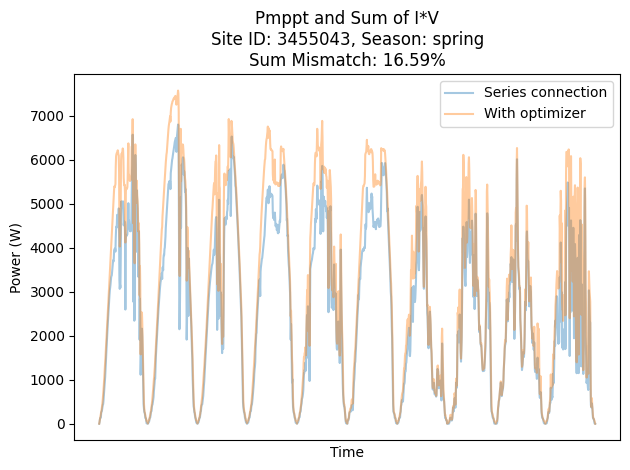

In [15]:
# Merge the pmppt_data with the iv_sum_data
combined_data = pd.concat([iv_sum_data, pmppt_data['Pmppt (W)']], axis=1)

# Add season and site ID columns to the combined data
combined_data['Season'] = season
combined_data['Site ID'] = site_id

# Export the combined data to an Excel file with season and site ID in the file name
excel_file = os.path.join(output_dir, f'combined_data_{season}_{site_id}.xlsx')
combined_data.to_excel(excel_file, index=False)

print(f"Combined data exported to: {excel_file}")

# Calculate the total energy of Sum of I*V and Pmppt
sum_iv_E = combined_data['Sum of I*V (W)'].sum()
pmppt_E = combined_data['Pmppt (W)'].sum()
sum_mismatch = (sum_iv_E - pmppt_E) / sum_iv_E

# Check if the lengths of Sum of I*V and Pmppt are the same
if len(combined_data['Sum of I*V (W)']) == len(combined_data['Pmppt (W)']):
    print("The lengths of Sum of I*V and Pmppt are the same.")
else:
    print("Warning: The lengths of Sum of I*V and Pmppt are not the same!")

# Print the total energy for both
print(f"Sum of I*V Energy: {sum_iv_E:.2f} W")
print(f"Pmppt Energy: {pmppt_E:.2f} W")

# Print the mean mismatch in percentage with 2 decimal places
print(f"Sum mismatch: {sum_mismatch * 100:.2f}%")

# Plot the Pmppt and Sum of I*V
fig, ax = plt.subplots()
ax.plot(combined_data['Timestamp'], combined_data['Pmppt (W)'], label='Series connection', alpha=0.4)
ax.plot(combined_data['Timestamp'], combined_data['Sum of I*V (W)'], label='With optimizer', alpha=0.4)
ax.set_xlabel('Time')
ax.set_ylabel('Power (W)')
# Include season and site ID in the title
ax.set_title(f'Pmppt and Sum of I*V\nSite ID: {site_id}, Season: {season}\nSum Mismatch: {sum_mismatch * 100:.2f}%')
ax.legend()
# Remove xticks
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.tight_layout()

# Save the plot to a PNG file
plot_file = os.path.join(output_dir, 'pmppt_vs_sum_iv.png')
fig.savefig(plot_file)
print(f"Plot exported to: {plot_file}")

plt.show()

### 3.1.2. Aggregate over each day

Date: 2024-09-20
Maximum IV Power: 6917.38 W (Exceeds 3000 W: True)
Daily Energy MPPT: 37224.51 Wh
Daily Energy IV: 46164.84 Wh
Daily Mismatch: 19.37%



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\z5183876\\OneDrive - UNSW\\Documents\\GitHub\\24_09_24_Solar_Edge\\Results\\v_from_i_combined/iv_curve_plots_20250427_235011_spring_3455043\\Daily_Comparison_for_2024-09-20_Site_ID_3455043_Season_spring_E_MPPT_3722451_Wh_E_IV_4616484_Wh_Max_IV_Power_691738_W_Mismatch_1937.png'

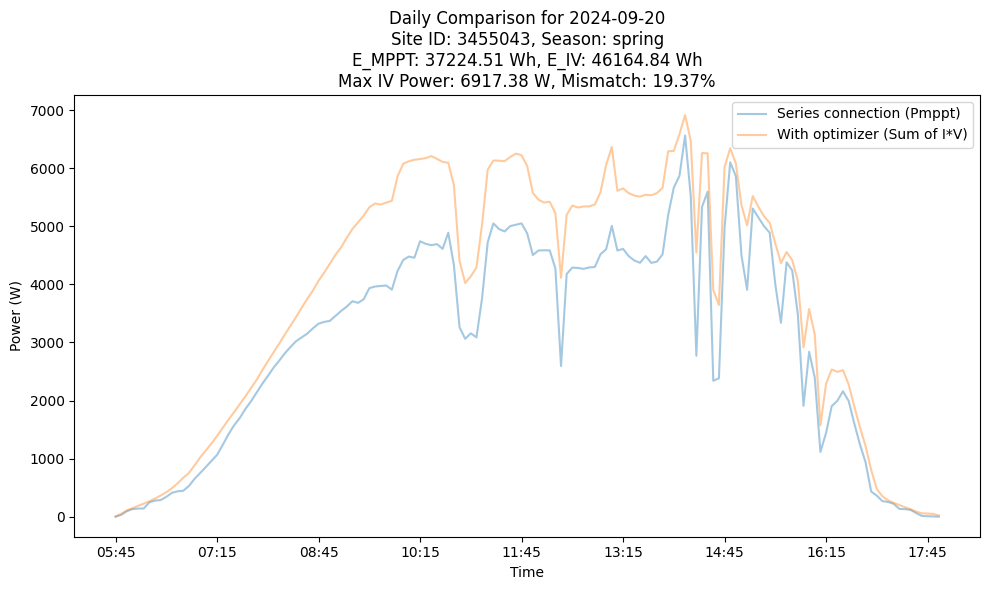

In [ ]:
# # perform filter
# perform_filter = False

# # Ensure Timestamp is in datetime format
# combined_data['Timestamp'] = pd.to_datetime(combined_data['Timestamp'])

# # Add a Date column to group by day
# combined_data['Date'] = combined_data['Timestamp'].dt.date

# # Calculate daily energy (convert power to energy in Wh)
# combined_data['Energy_IV (Wh)'] = combined_data['Sum of I*V (W)'] * (5 / 60)  # Convert 5-min data to Wh
# combined_data['Energy_MPPT (Wh)'] = combined_data['Pmppt (W)'] * (5 / 60)

# # Group by date and calculate daily sums
# daily_data = combined_data.groupby('Date')[['Energy_IV (Wh)', 'Energy_MPPT (Wh)']].sum()

# # Initialize variables for weighted average calculation
# weighted_sum_difference = 0
# total_energy = 0

# import re  # To clean title text for file names

# # Iterate over each day to calculate differences, check conditions, and plot
# for date, daily_row in daily_data.iterrows():
#     energy_iv_daily = daily_row['Energy_IV (Wh)']
#     energy_mppt_daily = daily_row['Energy_MPPT (Wh)']

#     # Calculate daily mismatch
#     daily_mismatch = (energy_iv_daily - energy_mppt_daily) / energy_iv_daily

#     # Filter data for the current day
#     day_data = combined_data[combined_data['Date'] == date]

#     # Calculate the maximum IV power for the day
#     max_iv_power = day_data['Sum of I*V (W)'].max()

#     # Only include days with max IV power > 3000 W in weighted mismatch calculation
#     if perform_filter:
#         if max_iv_power > 3000:
#             weighted_sum_difference += daily_mismatch * energy_iv_daily  # Weight by daily energy
#             total_energy += energy_iv_daily  # Use IV energy for weighting
#     else:
#         weighted_sum_difference += daily_mismatch * energy_iv_daily  # Weight by daily energy
#         total_energy += energy_iv_daily  # Use IV energy for weighting

#     # Log results
#     exceeds_3000W = max_iv_power > 3000
#     print(f"Date: {date}")
#     print(f"Maximum IV Power: {max_iv_power:.2f} W (Exceeds 3000 W: {exceeds_3000W})")
#     print(f"Daily Energy MPPT: {energy_mppt_daily:.2f} Wh")
#     print(f"Daily Energy IV: {energy_iv_daily:.2f} Wh")
#     print(f"Daily Mismatch: {daily_mismatch * 100:.2f}%\n")

#     # Plot the comparison for the day
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.plot(day_data['Timestamp'], day_data['Pmppt (W)'], label='Series connection (Pmppt)', alpha=0.4)
#     ax.plot(day_data['Timestamp'], day_data['Sum of I*V (W)'], label='With optimizer (Sum of I*V)', alpha=0.4)
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Power (W)')
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format x-axis as hours
#     ax.set_xticks(day_data['Timestamp'][::len(day_data) // 8])  # Set fewer ticks on x-axis

#     # Include daily details in the title
#     plot_title = (
#         f"Daily Comparison for {date}\n"
#         f"Site ID: {site_id}, Season: {season}\n"
#         f"E_MPPT: {energy_mppt_daily:.2f} Wh, E_IV: {energy_iv_daily:.2f} Wh\n"
#         f"Max IV Power: {max_iv_power:.2f} W, Mismatch: {daily_mismatch * 100:.2f}%"
#     )
#     ax.set_title(plot_title)
#     ax.legend()
#     plt.tight_layout()

#     # Generate a safe file name from the title
#     safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_').replace('\n', '_')
#     plot_file = os.path.join(output_dir, f"{safe_title}.png")

#     # Save the plot for each day
#     fig.savefig(plot_file)
#     print(f"Plot saved for {date}: {plot_file}\n")

#     plt.show()

# # Calculate the weighted average of daily percentage differences
# weighted_avg_mismatch = weighted_sum_difference / total_energy

# # Print the weighted average mismatch
# print(f"Weighted Average Daily Mismatch: {weighted_avg_mismatch * 100:.2f}%")


## 3.2. Check by timestamp

In [ ]:
# # input the timestamp to check
# timestamp = '2024-01-19 11:20:00'

# # extract the Pmppt and I*V sum for the timestamp from the combined data
# pmppt = combined_data.loc[combined_data['Timestamp'] == timestamp, 'Pmppt (W)'].values[0]
# sum_iv = combined_data.loc[combined_data['Timestamp'] == timestamp, 'Sum of I*V (W)'].values[0]

# # calculate the mismatch
# mismatch = 1 - pmppt / sum_iv

# # print the result
# print(f"Timestamp: {timestamp}")
# print(f"Pmppt: {pmppt:.2f} W")
# print(f"Sum of I*V: {sum_iv:.2f} W")
# print(f"Mismatch: {mismatch * 100:.2f}%")


# 4. J0 investigation

In [ ]:
# # ============================
# # Input Parameters
# # ============================
# # Directory where the J0 CSV file is located
# # results_dir = r'C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\iv_curve_plots_20250404_211059_spring_3794347'

# # Adjustable date range in 'YYYY-MM-DD' format (set to None to disable filtering)
# start_date = '2024-09-20 9:00'
# end_date   = '2024-09-20 18:59'



# # Define which optimizers to plot (list of column names). If None, all optimizer data will be plotted.
# selected_optimizers = ['241622317']  # Example: ['optimizer1', 'optimizer2']
# # selected_optimizers = ['241622317']  # Example: ['optimizer1', 'optimizer2']
# # selected_optimizers = None  # Set to None to plot all optimizers
# # ============================

# # Look for CSV files whose name contains 'J0' or 'j0'
# j0_files = [f for f in os.listdir(results_dir) if (('J0' in f) or ('j0' in f)) and f.endswith('.csv')]

# # Check if there are any files found
# if not j0_files:
#     print("No J0 files found in the results directory.")
# else:
#     # Read the first file found
#     j0_file = os.path.join(results_dir, j0_files[0])
#     try:
#         j0_df = pd.read_csv(j0_file, encoding='utf-8')
#     except UnicodeDecodeError:
#         print("UTF-8 encoding failed, trying latin1 encoding.")
#         j0_df = pd.read_csv(j0_file, encoding='latin1')

#     # Check the contents of the file
#     print(f"Contents of {j0_file}:")
#     print(j0_df.head())
#     print(f"Number of rows: {len(j0_df)}")

#     # Convert the Timestamp column to datetime and set it as the index, if available
#     if 'Timestamp' in j0_df.columns:
#         j0_df['Timestamp'] = pd.to_datetime(j0_df['Timestamp'])
#         j0_df.set_index('Timestamp', inplace=True)
#     else:
#         j0_df.index = pd.to_datetime(j0_df.index)
    
#     # Filter the DataFrame by date range if provided
#     if start_date is not None:
#         j0_df = j0_df[j0_df.index >= pd.to_datetime(start_date)]
#     if end_date is not None:
#         j0_df = j0_df[j0_df.index <= pd.to_datetime(end_date)]
    
#     # Filter columns if specific optimizers are defined
#     if selected_optimizers is not None:
#         # Ensure only existing columns are used
#         selected_columns = [opt for opt in selected_optimizers if opt in j0_df.columns]
#         j0_df = j0_df[selected_columns]
    
#     # Plot the data without legends
#     plt.figure(figsize=(12, 6))
#     for col in j0_df.columns:
#         plt.plot(j0_df.index, j0_df[col], label=col, alpha=0.5)
#     plt.xlabel('Timestamp')
#     plt.ylabel('J0')
#     plt.title('J0 over Time for Selected Optimizers')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\z5183876\\OneDrive - UNSW\\Documents\\GitHub\\24_09_24_Solar_Edge\\Results\\v_from_i_combined\\iv_curve_plots_20250404_211059_spring_3794347'